<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span><ul class="toc-item"><li><span><a href="#Données" data-toc-modified-id="Données-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Données</a></span></li></ul></li><li><span><a href="#Import" data-toc-modified-id="Import-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Import</a></span><ul class="toc-item"><li><span><a href="#Outils" data-toc-modified-id="Outils-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Outils</a></span></li></ul></li><li><span><a href="#S3-aws-avec-boto3" data-toc-modified-id="S3-aws-avec-boto3-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>S3 aws avec boto3</a></span><ul class="toc-item"><li><span><a href="#Credentials" data-toc-modified-id="Credentials-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Credentials</a></span></li></ul></li><li><span><a href="#Ajout-des-jars-manquants-sur-AWS-avec-sagemaker" data-toc-modified-id="Ajout-des-jars-manquants-sur-AWS-avec-sagemaker-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Ajout des jars manquants sur AWS avec sagemaker</a></span></li><li><span><a href="#Session-Spark" data-toc-modified-id="Session-Spark-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Session Spark</a></span><ul class="toc-item"><li><span><a href="#Info-sur-spark-et-la-session" data-toc-modified-id="Info-sur-spark-et-la-session-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Info sur spark et la session</a></span></li></ul></li><li><span><a href="#Load-dataframe" data-toc-modified-id="Load-dataframe-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Load dataframe</a></span><ul class="toc-item"><li><span><a href="#Dataframe-des-images-dans-S3" data-toc-modified-id="Dataframe-des-images-dans-S3-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Dataframe des images dans S3</a></span></li><li><span><a href="#Dataframe-des-images-en-locale" data-toc-modified-id="Dataframe-des-images-en-locale-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Dataframe des images en locale</a></span></li></ul></li><li><span><a href="#Resize" data-toc-modified-id="Resize-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Resize</a></span></li><li><span><a href="#Label-de-l'image" data-toc-modified-id="Label-de-l'image-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Label de l'image</a></span></li><li><span><a href="#Reduction-avec-PCA" data-toc-modified-id="Reduction-avec-PCA-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Reduction avec PCA</a></span><ul class="toc-item"><li><span><a href="#Création-d'un-vecteur-dense" data-toc-modified-id="Création-d'un-vecteur-dense-9.1"><span class="toc-item-num">9.1&nbsp;&nbsp;</span>Création d'un vecteur dense</a></span></li><li><span><a href="#MinMaxScaler-Scaler" data-toc-modified-id="MinMaxScaler-Scaler-9.2"><span class="toc-item-num">9.2&nbsp;&nbsp;</span>MinMaxScaler Scaler</a></span></li><li><span><a href="#PCA" data-toc-modified-id="PCA-9.3"><span class="toc-item-num">9.3&nbsp;&nbsp;</span>PCA</a></span></li><li><span><a href="#Save-Dataframe" data-toc-modified-id="Save-Dataframe-9.4"><span class="toc-item-num">9.4&nbsp;&nbsp;</span>Save Dataframe</a></span></li></ul></li><li><span><a href="#GIT" data-toc-modified-id="GIT-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>GIT</a></span></li><li><span><a href="#Bibliography" data-toc-modified-id="Bibliography-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Bibliography</a></span></li></ul></div>

# Introduction

Dans un environnement Big Data, une première chaîne de traitement des données qui comprendra le preprocessing et une étape de réduction de dimension.
La sortie de la réduction de dimension (une matrice écrite sur un fichier CSV ou autre) est ecrite dans un espace de stockage sur le cloud.



## Données

https://www.kaggle.com/datasets/moltean/fruits?select=fruits-360_dataset


# Import


In [1]:
# sagemaker

import sagemaker_pyspark

# pyspark

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import split, udf, col, pandas_udf, PandasUDFType
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, ArrayType, BinaryType, DoubleType, DataType, FloatType
from pyspark.ml.image import ImageSchema
from pyspark.ml.feature import PCA, MinMaxScaler
from pyspark.ml.linalg import Vectors, VectorUDT, DenseVector

from typing import Iterator

# image
from PIL import Image, ImageDraw


# Outils
import numpy as np
import pandas as pd
import sys
import os
import io
import time
from contextlib import contextmanager


import boto3


## Outils


In [2]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))


In [3]:
s3bucket = 'ocunderscorep8'
debug_folder = 'fruits-360-debug/Training/'
full_folder = 'fruits-360/Training/'

# S3 aws avec boto3


https://us-east-1.console.aws.amazon.com/iam/home#/users$new?step=permissions&accessKey&userNames=app_p8&permissionType=policies

In [4]:
session = boto3.session.Session(aws_access_key_id="",
                                        aws_secret_access_key="")
s3_client = session.client(service_name='s3')
prefix = debug_folder #fruits-360/Training/
sub_folders = s3_client.list_objects_v2(Bucket=s3bucket, Prefix=prefix)


Mes buckets sur s3

In [5]:
s3_client.list_buckets()

{'ResponseMetadata': {'RequestId': '7HGBBF9FQMP9AXEQ',
  'HostId': 'eaPZHYQfoVRElZXYaZZO68RsRFNzANvxzl4xesARrIVu1YYIRTschDB537k/+muGjfYTyTIXye8=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'eaPZHYQfoVRElZXYaZZO68RsRFNzANvxzl4xesARrIVu1YYIRTschDB537k/+muGjfYTyTIXye8=',
   'x-amz-request-id': '7HGBBF9FQMP9AXEQ',
   'date': 'Sat, 26 Nov 2022 22:20:36 GMT',
   'content-type': 'application/xml',
   'transfer-encoding': 'chunked',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'Buckets': [{'Name': 'aws-logs-479126531994-eu-west-3',
   'CreationDate': datetime.datetime(2022, 11, 13, 21, 40, 19, tzinfo=tzlocal())},
  {'Name': 'ocunderscorep8',
   'CreationDate': datetime.datetime(2022, 11, 11, 15, 9, 24, tzinfo=tzlocal())},
  {'Name': 'sagemaker-studio-479126531994-bb9tbgaoy2h',
   'CreationDate': datetime.datetime(2022, 11, 19, 21, 26, 35, tzinfo=tzlocal())}],
 'Owner': {'ID': '6f787a108b861a0c711fcad4e301e7d39d745f76275b17fc6f38c82563b80cb0'}}

Mes subfolder sur S3

In [6]:
sub_folders

{'ResponseMetadata': {'RequestId': 'JYMBZ93Z4V054X6W',
  'HostId': 'TPdY5qAQ6BF6OQaWxxw5wae8wv7fhDFNr8RooUNVEFZfIrKlKLfkUGvih/ij/KTNUh9OygdMGEg=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'TPdY5qAQ6BF6OQaWxxw5wae8wv7fhDFNr8RooUNVEFZfIrKlKLfkUGvih/ij/KTNUh9OygdMGEg=',
   'x-amz-request-id': 'JYMBZ93Z4V054X6W',
   'date': 'Sat, 26 Nov 2022 22:20:35 GMT',
   'x-amz-bucket-region': 'eu-west-3',
   'content-type': 'application/xml',
   'transfer-encoding': 'chunked',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'IsTruncated': True,
 'Contents': [{'Key': 'fruits-360-debug/Training/Apple_Braeburn/0_100.jpg',
   'LastModified': datetime.datetime(2022, 11, 23, 16, 2, 8, tzinfo=tzlocal()),
   'ETag': '"2247c5e506d29555ba9bcd403cf29330"',
   'Size': 4773,
   'StorageClass': 'STANDARD'},
  {'Key': 'fruits-360-debug/Training/Apple_Braeburn/100_100.jpg',
   'LastModified': datetime.datetime(2022, 11, 23, 16, 2, 8, tzinfo=tzlocal()),
   'ETag': '"324fa5ff9895272562590258c73ffe18"

In [7]:
paths =  []
for key in sub_folders["Contents"]:
    file = key["Key"]
    paths.append("s3://ocunderscorep8/" + file)
paths

['s3://ocunderscorep8/fruits-360-debug/Training/Apple_Braeburn/0_100.jpg',
 's3://ocunderscorep8/fruits-360-debug/Training/Apple_Braeburn/100_100.jpg',
 's3://ocunderscorep8/fruits-360-debug/Training/Apple_Braeburn/101_100.jpg',
 's3://ocunderscorep8/fruits-360-debug/Training/Apple_Braeburn/102_100.jpg',
 's3://ocunderscorep8/fruits-360-debug/Training/Apple_Braeburn/103_100.jpg',
 's3://ocunderscorep8/fruits-360-debug/Training/Apple_Braeburn/104_100.jpg',
 's3://ocunderscorep8/fruits-360-debug/Training/Apple_Braeburn/105_100.jpg',
 's3://ocunderscorep8/fruits-360-debug/Training/Apple_Braeburn/106_100.jpg',
 's3://ocunderscorep8/fruits-360-debug/Training/Apple_Braeburn/107_100.jpg',
 's3://ocunderscorep8/fruits-360-debug/Training/Apple_Braeburn/108_100.jpg',
 's3://ocunderscorep8/fruits-360-debug/Training/Apple_Braeburn/109_100.jpg',
 's3://ocunderscorep8/fruits-360-debug/Training/Apple_Braeburn/10_100.jpg',
 's3://ocunderscorep8/fruits-360-debug/Training/Apple_Braeburn/110_100.jpg',
 '

## Credentials

En local, j'utilise mes credentials root, ce qui en soi est "mal". Mais il s'agit d'un petit projet sans suite.

In [8]:
credentials = session.get_credentials()
AWS_ACCESS_KEY_ID = credentials.access_key
AWS_SECRET_ACCESS_KEY = credentials.secret_key

# Ajout des jars manquants sur AWS avec sagemaker

En local, j'ai ajouté les jars manquants au folder (voir Bibliography)

In [8]:
classpath = ":".join(sagemaker_pyspark.classpath_jars())


# Session Spark

Por la version sur sagemaker, j'ajoute .config("spark.driver.extraClassPath", classpath)


In [10]:
spark = SparkSession.builder.appName("oc_p8").config(
        "spark.driver.extraClassPath", classpath).config("spark.driver.memory", "18g").getOrCreate()
spark.sparkContext.setLogLevel("WARN")

22/11/26 22:21:28 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


## Info sur spark et la session

In [11]:

spark


In [12]:
sc = spark.sparkContext
print(f"Hadoop version = {sc._jvm.org.apache.hadoop.util.VersionInfo.getVersion()}")

Hadoop version = 3.3.2


# Load dataframe

In [13]:
def load_data(path):
    #chargement dataframe des images
    df_img = spark.read.format("image").option("recursiveFileLookup", True).option("dropInvalid", True).load(path)
    print(df_img.printSchema())
    return df_img

## Dataframe des images dans S3

(En local, j'ai du ajouter 3 jars qui manquaient. Voir bibliographie.)



In [14]:
dfS3_img =load_data('s3a://ocunderscorep8/fruits-360-debug/Training/*')

22/11/26 22:22:34 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties
root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)

None


In [15]:
dfS3_img.select("image.origin", "image.height", "image.width", "image.nChannels", "image.mode", "image.data" ).show(truncate=30)

+------------------------------+------+-----+---------+----+------------------------------+
|                        origin|height|width|nChannels|mode|                          data|
+------------------------------+------+-----+---------+----+------------------------------+
|s3a://ocunderscorep8/fruits...|   100|  100|        3|  16|[FF FF FF FF FF FF FF FF FF...|
|s3a://ocunderscorep8/fruits...|   100|  100|        3|  16|[FD FF FF FD FF FF FD FF FF...|
|s3a://ocunderscorep8/fruits...|   100|  100|        3|  16|[FF FF FF FF FF FF FF FF FF...|
|s3a://ocunderscorep8/fruits...|   100|  100|        3|  16|[FF FF FF FF FF FF FF FF FF...|
|s3a://ocunderscorep8/fruits...|   100|  100|        3|  16|[FF FF FF FF FF FF FF FF FF...|
|s3a://ocunderscorep8/fruits...|   100|  100|        3|  16|[FF FF FF FF FF FF FF FF FF...|
|s3a://ocunderscorep8/fruits...|   100|  100|        3|  16|[FF FF FF FF FF FF FF FF FF...|
|s3a://ocunderscorep8/fruits...|   100|  100|        3|  16|[FF FF FF FF FF FF F

## Dataframe des images en locale



In [22]:


df_img =load_data(debug_folder)


root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)

None


In [12]:
df_img.select("image.origin", "image.height", "image.width", "image.nChannels", "image.mode", "image.data" ).show(truncate=30)

+------------------------------+------+-----+---------+----+------------------------------+
|                        origin|height|width|nChannels|mode|                          data|
+------------------------------+------+-----+---------+----+------------------------------+
|file:///Users/mcBedini/Docu...|   100|  100|        3|  16|[FF FF FF FF FF FF FF FF FF...|
|file:///Users/mcBedini/Docu...|   100|  100|        3|  16|[FD FF FF FD FF FF FD FF FF...|
|file:///Users/mcBedini/Docu...|   100|  100|        3|  16|[FF FF FF FF FF FF FF FF FF...|
|file:///Users/mcBedini/Docu...|   100|  100|        3|  16|[FF FF FF FF FF FF FF FF FF...|
|file:///Users/mcBedini/Docu...|   100|  100|        3|  16|[FF FF FF FF FF FF FF FF FF...|
|file:///Users/mcBedini/Docu...|   100|  100|        3|  16|[FF FF FF FF FF FF FF FF FF...|
|file:///Users/mcBedini/Docu...|   100|  100|        3|  16|[FF FF FF FF FF FF FF FF FF...|
|file:///Users/mcBedini/Docu...|   100|  100|        3|  16|[FF FF FF FF FF FF F

Les données de l'image sont un array de 30000 elements (100\*100\*3)

In [16]:
row=dfS3_img.first()
print(len(row[0].__getitem__('data')))

30000


Affichage de l'image de la première ligne, une pastèque

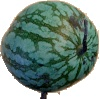

In [17]:
spark_single_img = dfS3_img.first()
(spark_single_img.image.origin, spark_single_img.image.mode, spark_single_img.image.nChannels )

mode = 'RGBA' if (spark_single_img.image.nChannels == 4) else 'RGB' 
Image.frombytes(mode=mode, data=bytes(spark_single_img.image.data), size=[spark_single_img.image.width,spark_single_img.image.height]).show()


de BGR à RGB : une pastèque moins bleutée

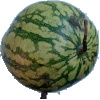

In [18]:
def convert_bgr_array_to_rgb_array(img_array):
    B, G, R = img_array.T
    return np.array((R, G, B)).T

img = Image.frombytes(mode=mode, data=bytes(spark_single_img.image.data), size=[spark_single_img.image.width,spark_single_img.image.height])

converted_img_array = convert_bgr_array_to_rgb_array(np.asarray(img))
Image.fromarray(converted_img_array).show()

# Resize

In [19]:
schema = StructType(dfS3_img.select("image.*").schema.fields + [
    StructField("data_as_resized_array", ArrayType(IntegerType()), True),
    StructField("data_as_array", ArrayType(IntegerType()), True)
])

def resize_img(img_data, resize=True):
    mode = 'RGBA' if (img_data.nChannels == 4) else 'RGB' 
    img = Image.frombytes(mode=mode, data=img_data.data, size=[img_data.width, img_data.height])
    img = img.convert('RGB') if (mode == 'RGBA') else img
    img = img.resize([40, 40], resample=Image.BICUBIC) if (resize) else img
    arr = convert_bgr_array_to_rgb_array(np.asarray(img))
    arr = arr.reshape([40*40*3]) if (resize) else arr.reshape([img_data.width*img_data.height*3])

    return arr

def resize_image_udf(dataframe_batch_iterator: Iterator[pd.DataFrame]) -> Iterator[pd.DataFrame]:
    for dataframe_batch in dataframe_batch_iterator:
        dataframe_batch["data_as_resized_array"] = dataframe_batch.apply(resize_img, args=(True,), axis=1)
        dataframe_batch["data_as_array"] = dataframe_batch.apply(resize_img, args=(False,), axis=1)
        yield dataframe_batch



In [20]:
resized_df = dfS3_img.select("image.*").mapInPandas(resize_image_udf, schema)

In [21]:
row=resized_df.first()
print(len(row.__getitem__('data_as_resized_array')))

4800


In [22]:
dfS3_img.unpersist()


DataFrame[image: struct<origin:string,height:int,width:int,nChannels:int,mode:int,data:binary>]

# Label de l'image

Je simplifie les labels avec un udf. Toutes les sous-catégories (ex. Pear 1, Pear 2) sont groupées dans une catégorie (ex. Pear).



In [23]:
def set_label(path):
        return path.split('/')[-2].split('_')[0]
udf_label = udf(set_label, StringType())

def labelize(df):
    return df.withColumn('Label', udf_label("origin"))

resized_df = labelize(resized_df)


In [24]:
resized_df.show()

+--------------------+------+-----+---------+----+--------------------+---------------------+--------------------+----------+
|              origin|height|width|nChannels|mode|                data|data_as_resized_array|       data_as_array|     Label|
+--------------------+------+-----+---------+----+--------------------+---------------------+--------------------+----------+
|s3a://ocunderscor...|   100|  100|        3|  16|[FF FF FF FF FF F...| [255, 255, 255, 2...|[255, 255, 255, 2...|Watermelon|
|s3a://ocunderscor...|   100|  100|        3|  16|[FD FF FF FD FF F...| [255, 255, 253, 2...|[255, 255, 253, 2...|Watermelon|
|s3a://ocunderscor...|   100|  100|        3|  16|[FF FF FF FF FF F...| [255, 255, 255, 2...|[255, 255, 255, 2...|Watermelon|
|s3a://ocunderscor...|   100|  100|        3|  16|[FF FF FF FF FF F...| [255, 255, 255, 2...|[255, 255, 255, 2...|Watermelon|
|s3a://ocunderscor...|   100|  100|        3|  16|[FF FF FF FF FF F...| [255, 255, 255, 2...|[255, 255, 255, 2...|Wate

# Reduction avec PCA

Inspiré par : https://stackoverflow.com/questions/73654149/pyspark-image-dimension-reduction-with-pca

## Création d'un vecteur dense

à partir de image.data. image.data est un vecteur : https://github.com/apache/spark/blob/master/mllib/src/main/scala/org/apache/spark/ml/image/ImageSchema.scala#L131-L190 With a 640 x 480 RGB image example, the first three positions of the array will contain color information(Blue, Green and Red) from the pixel at height = 0 and width = 0. The next three position will contain information from the pixel at at height = 0 and width = 1 and so on. (https://towardsdatascience.com/image-segmentation-on-apache-spark-46164dd53c73)

In [25]:
ud_img2vec = udf(lambda x : Vectors.dense(x), VectorUDT())

resized_df = resized_df.withColumn("data_as_vector", ud_img2vec("data"))

resized_df.show(truncate=45)

+---------------------------------------------+------+-----+---------+----+---------------------------------------------+---------------------------------------------+---------------------------------------------+----------+---------------------------------------------+
|                                       origin|height|width|nChannels|mode|                                         data|                        data_as_resized_array|                                data_as_array|     Label|                               data_as_vector|
+---------------------------------------------+------+-----+---------+----+---------------------------------------------+---------------------------------------------+---------------------------------------------+----------+---------------------------------------------+
|s3a://ocunderscorep8/fruits-360-debug/Trai...|   100|  100|        3|  16|[FF FF FF FF FF FF FF FF FF FF FF FF FF FF...|[255, 255, 255, 255, 255, 255, 255, 255, 2...|[255, 255, 255, 255,

Je ne garde que les colonnes utiles pour ma proof of concept

In [26]:
resized_df=resized_df.select('origin', 'Label', 'data_as_vector')
resized_df.show()

+--------------------+----------+--------------------+
|              origin|     Label|      data_as_vector|
+--------------------+----------+--------------------+
|s3a://ocunderscor...|Watermelon|[255.0,255.0,255....|
|s3a://ocunderscor...|Watermelon|[253.0,255.0,255....|
|s3a://ocunderscor...|Watermelon|[255.0,255.0,255....|
|s3a://ocunderscor...|Watermelon|[255.0,255.0,255....|
|s3a://ocunderscor...|Watermelon|[255.0,255.0,255....|
|s3a://ocunderscor...|Watermelon|[255.0,255.0,255....|
|s3a://ocunderscor...|Watermelon|[255.0,255.0,255....|
|s3a://ocunderscor...|Watermelon|[255.0,255.0,255....|
|s3a://ocunderscor...|Watermelon|[255.0,255.0,255....|
|s3a://ocunderscor...|Watermelon|[255.0,255.0,255....|
|s3a://ocunderscor...|Watermelon|[255.0,255.0,255....|
|s3a://ocunderscor...|Watermelon|[255.0,255.0,255....|
|s3a://ocunderscor...|Watermelon|[255.0,255.0,255....|
|s3a://ocunderscor...|Watermelon|[255.0,255.0,254....|
|s3a://ocunderscor...|Watermelon|[255.0,255.0,255....|
|s3a://ocu

## MinMaxScaler Scaler


**/!\ Il faut modifer les noms de folder et remplacer les espaces par des underscore, sinon on a une erreur dans le fit.**

In [27]:
standardizer = MinMaxScaler(inputCol="data_as_vector", 
                            outputCol="scaledFeatures",
                            min=-1.0,
                            max=1.0)
model_std = standardizer.fit(resized_df)
resized_df = model_std.transform(resized_df)


In [28]:
resized_df.show()

+--------------------+----------+--------------------+--------------------+
|              origin|     Label|      data_as_vector|      scaledFeatures|
+--------------------+----------+--------------------+--------------------+
|s3a://ocunderscor...|Watermelon|[255.0,255.0,255....|[1.0,1.0,1.0,1.0,...|
|s3a://ocunderscor...|Watermelon|[253.0,255.0,255....|[0.66666666666666...|
|s3a://ocunderscor...|Watermelon|[255.0,255.0,255....|[1.0,1.0,1.0,1.0,...|
|s3a://ocunderscor...|Watermelon|[255.0,255.0,255....|[1.0,1.0,1.0,1.0,...|
|s3a://ocunderscor...|Watermelon|[255.0,255.0,255....|[1.0,1.0,1.0,1.0,...|
|s3a://ocunderscor...|Watermelon|[255.0,255.0,255....|[1.0,1.0,1.0,1.0,...|
|s3a://ocunderscor...|Watermelon|[255.0,255.0,255....|[1.0,1.0,1.0,1.0,...|
|s3a://ocunderscor...|Watermelon|[255.0,255.0,255....|[1.0,1.0,1.0,1.0,...|
|s3a://ocunderscor...|Watermelon|[255.0,255.0,255....|[1.0,1.0,1.0,1.0,...|
|s3a://ocunderscor...|Watermelon|[255.0,255.0,255....|[1.0,1.0,1.0,1.0,...|
|s3a://ocund


## PCA

22/11/14 17:18:18 WARN RowMatrix: 30000 columns will require at least 7200 megabytes of memory!

In [29]:
# algorithm
pca = PCA(k=50, inputCol='scaledFeatures', outputCol='pcaFeatures')
model_pca = pca.fit(resized_df)



22/11/26 22:25:51 WARN RowMatrix: 30000 columns will require at least 7200 megabytes of memory!


22/11/26 22:26:23 ERROR Executor: Exception in task 7.0 in stage 16.0 (TID 162)
java.lang.OutOfMemoryError: Java heap space
	at scala.reflect.ManifestFactory$DoubleManifest.newArray(Manifest.scala:194)
	at scala.reflect.ManifestFactory$DoubleManifest.newArray(Manifest.scala:191)
	at breeze.linalg.DenseVector$mcD$sp.<init>(DenseVector.scala:66)
	at org.apache.spark.mllib.linalg.distributed.RowMatrix.$anonfun$computeDenseVectorCovariance$1(RowMatrix.scala:175)
	at org.apache.spark.mllib.linalg.distributed.RowMatrix$$Lambda$3775/0x0000000801902040.apply(Unknown Source)
	at scala.collection.TraversableOnce$folder$1.apply(TraversableOnce.scala:196)
	at scala.collection.TraversableOnce$folder$1.apply(TraversableOnce.scala:194)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.TraversableOnce.foldLeft(TraversableOnce.scala:199)
	at scala.co

22/11/26 22:26:23 WARN TaskSetManager: Lost task 7.0 in stage 16.0 (TID 162) (ip-172-16-46-1.eu-west-3.compute.internal executor driver): java.lang.OutOfMemoryError: Java heap space
	at scala.reflect.ManifestFactory$DoubleManifest.newArray(Manifest.scala:194)
	at scala.reflect.ManifestFactory$DoubleManifest.newArray(Manifest.scala:191)
	at breeze.linalg.DenseVector$mcD$sp.<init>(DenseVector.scala:66)
	at org.apache.spark.mllib.linalg.distributed.RowMatrix.$anonfun$computeDenseVectorCovariance$1(RowMatrix.scala:175)
	at org.apache.spark.mllib.linalg.distributed.RowMatrix$$Lambda$3775/0x0000000801902040.apply(Unknown Source)
	at scala.collection.TraversableOnce$folder$1.apply(TraversableOnce.scala:196)
	at scala.collection.TraversableOnce$folder$1.apply(TraversableOnce.scala:194)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.Traver

22/11/26 22:26:23 ERROR Executor: Exception in task 4.0 in stage 16.0 (TID 159)
java.lang.OutOfMemoryError: Java heap space
22/11/26 22:26:23 ERROR SparkUncaughtExceptionHandler: [Container in shutdown] Uncaught exception in thread Thread[Executor task launch worker for task 4.0 in stage 16.0 (TID 159),5,main]
java.lang.OutOfMemoryError: Java heap space
22/11/26 22:26:24 ERROR Executor: Exception in task 6.0 in stage 16.0 (TID 161)
java.lang.OutOfMemoryError: Java heap space
22/11/26 22:26:24 ERROR SparkUncaughtExceptionHandler: [Container in shutdown] Uncaught exception in thread Thread[Executor task launch worker for task 6.0 in stage 16.0 (TID 161),5,main]
java.lang.OutOfMemoryError: Java heap space
22/11/26 22:26:24 ERROR Executor: Exception in task 1.0 in stage 16.0 (TID 156)
java.lang.OutOfMemoryError: Java heap space
22/11/26 22:26:24 ERROR SparkUncaughtExceptionHandler: [Container in shutdown] Uncaught exception in thread Thread[Executor task launch worker for task 1.0 in stage

----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 58558)
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.8/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.8/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.8/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.8/socketserver.py", line 747, in __init__
    self.handle()
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/pyspark/accumulators.py", line 281, in handle
    poll(accum_updates)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/pyspark/accumulators.py", l

Py4JError: py4j.reflection does not exist in the JVM

In [ ]:
# Transformation
df = model_pca.transform(df)
    
df.show()

## Save Dataframe


In [17]:
path='s3a://ocunderscorep8/fruits-360-debug'
path=path + '/parquet.parquet'
df.write.format("parquet").mode('overwrite').save(path)


In [19]:
def write_where(path):
    if path == 'S3':
        return 's3a://ocunderscorep8/fruits-360-debug/parquet.parquet'
    else :
        return 'parquet.parquet'

path=write_where('S3')
df.write.format("parquet").mode('overwrite').save(path)


# GIT

https://github.com/cbedini/oc_p8


# Bibliography


Spark

https://medium.com/@AaronSchlegel/install-spark-on-macos-and-load-data-from-aws-s3-with-pyspark-6884bd5f0d90


Pyspark

https://livebook.manning.com/book/pyspark-in-action/chapter-3/1

https://anujsyal.com/pyspark-installation-guide


Example alternatif

https://docs.databricks.com/_static/notebooks/deep-learning/deep-learning-transfer-learning-keras.html

https://stackoverflow.com/questions/55377712/not-able-to-import-sparkdl-in-jupyter-notebook

https://towardsdatascience.com/image-segmentation-on-apache-spark-46164dd53c73


Spark Context, Session

https://medium.com/@achilleus/spark-session-10d0d66d1d24


AWS CLI envvars

https://docs.aws.amazon.com/cli/latest/userguide/cli-configure-envvars.html


CLI, Boto3

https://www.carolynlangen.com/blog/2017-11-22-interacting-with-aws-s3-using-python-in-a-jupyter-notebook/


Boto3

https://medium.com/@antonysruthy11/loading-kaggle-dataset-to-aws-s3-using-boto3-50af3e015fb2

https://towardsdatascience.com/reading-and-writing-files-from-to-amazon-s3-with-pandas-ccaf90bfe86c




Images processing

https://godatadriven.com/blog/real-distributed-image-processing-with-apache-spark/

https://stackoverflow.com/questions/69205589/how-preprocess-image-using-pyspark

https://www.databricks.com/blog/2018/12/10/introducing-built-in-image-data-source-in-apache-spark-2-4.html

https://spark.apache.org/docs/latest/ml-datasource.html


UDF

https://stackoverflow.com/questions/50222362/pyspark-split-the-string-column-and-join-part-of-them-to-form-new-columns


PCA

https://people.duke.edu/~ccc14/sta-663-2016/21D_Spark_MLib.html

https://stackoverflow.com/questions/73654149/pyspark-image-dimension-reduction-with-pca

https://towardsdatascience.com/image-compression-using-principal-component-analysis-pca-253f26740a9f

https://medium.com/@david.kabii/pyspark-feature-engineering-and-high-dimensional-data-visualization-with-spark-sql-in-an-hour-b2fea0de2472


PCA sur R, G, B

https://towardsdatascience.com/dimensionality-reduction-of-a-color-photo-splitting-into-rgb-channels-using-pca-algorithm-in-python-ba01580a1118


Upload data sur S3

https://manan.au/data-platforms/amazon-aws/loading-data-from-kaggle-to-amazon-s3-bucket/


s3a jars

https://stackoverflow.com/questions/58415928/spark-s3-error-java-lang-classnotfoundexception-class-org-apache-hadoop-f

https://stackoverflow.com/questions/64563127/pyspark-s3-error-java-lang-noclassdeffounderror-com-amazonaws-services-s3-mode

http://deploymentzone.com/2015/12/20/s3a-on-spark-on-aws-ec2/

https://medium.com/@erkansirin/apache-spark-aws-s3-datasource-eb65ee906e64

https://medium.com/@AaronSchlegel/install-spark-on-macos-and-load-data-from-aws-s3-with-pyspark-6884bd5f0d90

https://notadatascientist.com/running-apache-spark-and-s3-locally/

https://aws.amazon.com/fr/premiumsupport/knowledge-center/emr-spark-classnotfoundexception/

et AWS https://anujsyal.com/pyspark-installation-guide


Sagemaker et SparkMagic

https://www.google.com/search?q=run+pyspark+noebook+on+sagemaker+studio&oq=run+pyspark+noebook+on+sagemaker&aqs=chrome.1.69i57j33i10i160j33i22i29i30.14697j0j7&sourceid=chrome&ie=UTF-8#fpstate=ive&vld=cid:6652f735,vid:RxRENYQBxZU


Parquet

https://www.databricks.com/glossary/what-is-parquet



Alternative à SageMaker

https://towardsdatascience.com/setting-up-and-using-jupyter-notebooks-on-aws-61a9648db6c5

https://docs.aws.amazon.com/emr/latest/ManagementGuide/emr-managed-notebooks-headless-cli.html

https://medium.com/swlh/running-pyspark-applications-on-amazon-emr-e536b7a865ca


SSH

https://modelpredict.com/sagemaker-ssh-setup/




Unpersist

https://stackoverflow.com/questions/53072838/how-to-drop-dataframes-from-pyspark-to-manage-memory


PySpark: java.lang.OutofMemoryError


https://stackoverflow.com/questions/21138751/spark-java-lang-outofmemoryerror-java-heap-space

https://stackoverflow.com/questions/64551151/spark-java-pca-java-heap-space-and-missing-output-location-for-shuffle

https://stackoverflow.com/questions/37335/how-to-deal-with-java-lang-outofmemoryerror-java-heap-space-error

https://stackoverflow.com/questions/8393531/doing-pca-in-java-on-large-matrix

https://stackoverflow.com/questions/32336915/pyspark-java-lang-outofmemoryerror-java-heap-space

https://aws.amazon.com/premiumsupport/knowledge-center/glue-oom-java-heap-space-error/

https://docs.aws.amazon.com/glue/latest/dg/monitor-profile-debug-oom-abnormalities.html#monitor-debug-oom-fix

https://aws.amazon.com/blogs/big-data/best-practices-for-successfully-managing-memory-for-apache-spark-applications-on-amazon-emr/

https://stackoverflow.com/questions/31428581/incremental-pca-on-big-data